In [1]:
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt
%matplotlib inline 

from scipy.special import gamma

In [2]:
def ft_phase_screen(r0=0.1, N=2048, delta=0.0025, L0=1000, l0=0.001, verbose=False):
    start = time.time()
    delta_f = 1/(N*delta) # delta is the sampling interval (periodicity), delta_f is the wavenumber increment
    f_x = np.arange(-np.floor(N/2), np.floor(N/2)) * delta_f
    f_x, f_y = np.meshgrid(f_x, -f_x)
    
    def cart2pol(x, y):
        f = np.sqrt(x**2 + y**2)
        th = np.arctan2(y, x)
        return th, f
    
    th, f = cart2pol(f_x, f_y)
    f_m = 5.92/l0/(2*np.pi)
    f_0 = 1/L0
    
    nae = 22/6.0 #Normalized alpha value
    Bnume = gamma(nae/2.0)
    Bdenome = 2.0**(2.0-nae)*np.pi*nae*gamma(-nae/2.0)
    conee = (2.0* (8.0/(nae-2.0) *gamma(2.0/(nae-2.0)))**((nae-2.0)/2.0))
    Bface = (2.0*np.pi)**(2.0-nae) * (Bnume/Bdenome)
    ae = gamma(nae-1.0)*np.cos(nae*np.pi/2.0)/(4.0*np.pi**2.0)
    c_ae = (gamma(0.5*(5.0-nae))*ae*2.0*np.pi/3.0)**(1.0/(nae-5.0))
    fme = c_ae/l0   # Inner scale frequency(1/m)
    f_m = fme
    
    #f_m = 5.92/l0/(2*np.pi)
    #Power Spectral Density of 
    # phase power spectral density for the Kolmogorov refractive index power spectral density 
    PSD_phi = 0.023 * r0 ** (-5/3) * np.exp(-(f/f_m)**2) / ((f**2 + f_0**2) ** (11/6))
    PSD_phi[int(N/2),int(N/2)] = 0
    
    
    #  ... an NxN field of pseudorandom complex numbers is multiplied by sqrt of the Power Spectral Density (PSD)
    # divided by the wavenumber increment (delta) and inverse transformed by 2-D discrete Fourier Transform (DFT)
    # to yield the desired random phase field 
    #im = np.random.normal(size=(N, N))
    #re = np.random.normal(size=(N, N))
    #cn = (1j*im + re) * np.sqrt(PSD_phi) * delta_f 
    cn = (np.random.randn(N, N) + 1j*np.random.randn(N, N) )
    cn = cn * np.sqrt(PSD_phi)*delta_f
    
    def ift2(G, delta_f):
        N, N = G.shape
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(G))) * (N * delta_f)**2
    
    #phz = np.real(ift2(cn, 1))
    
    phz_temp  = np.fft.ifft2(np.fft.fftshift(cn))*((N)**2)
    phz_temp  = np.fft.ifftshift(phz_temp)
    phz1 = np.real(phz_temp)
    
    if verbose: print("time: ", start-time.time())
    return phz1 # returns phase screen with variations in radians

In [56]:
r0=0.636
N=512
delta=0.005
L0=10
l0=0.001

wvl = 0.532e-6            # Optical wavelenght [m]
propDist = 10e3       # propagation distance [m]

In [4]:
start = time.time()
realizations = []
for i in range(20):
    realization = ft_phase_screen(r0=r0, N=N, delta=delta, L0=L0, l0=l0)
    end = time.time()
    print(end-start)
    start=end
    realizations.extend(realization.reshape([1, realization.size])[0])

0.1856849193572998
0.17183732986450195
0.17142510414123535
0.16689205169677734
0.17389512062072754
0.1329331398010254
0.129319429397583
0.13504290580749512
0.13064980506896973
0.13062047958374023
0.1340348720550537
0.13233375549316406
0.13424181938171387
0.14017486572265625
0.13740754127502441
0.13355088233947754
0.13510370254516602
0.1289820671081543
0.13358211517333984
0.1343555450439453


In [5]:
phz = ft_phase_screen(r0=r0, N=4096, delta=delta, L0=10, l0=.10)

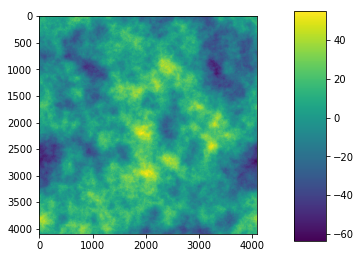

In [6]:
plt.imshow(phz.real)#.set_clim(0.0, 2)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [41]:
def SplitStepProp(Uin, wvl, phaseScreenStack, dx):
    Rdx = dx
    N, N = Uin.shape
    nx = np.arange(-np.floor(N/2), np.floor(N/2))
    nx, ny = np.meshgrid(nx, nx)
    k = 2 * np.pi / wvl
    
    r1 = np.sqrt(nx**2 + ny**2) # radius
    
    # Super Gaussian absorbing boundary
    def MakeSGB(sigma=0.55):
        rad = np.sqrt(nx**2 + ny**2) # radius
        w = sigma*N 
        sg = np.exp(-(( rad / w)**16)) # Flatte et al use a SG with n=8
        
        return sg
    
    sg = MakeSGB(sigma=0.45)
    
    sg = plane = np.ones([N, N])
    
    # Propagation Geometry   
    numScr = phaseScreenStack.shape[2]
    
    dzProps = np.ones(numScr + 2) * (propDist / numScr)
    dzProps[0:2] = 0.5 * (propDist / numScr)
    dzProps[numScr:numScr+2] = 0.5 * (propDist / numScr)

    propLocs = np.zeros(numScr + 3)

    for zval in range(0, numScr+2):
        propLocs[zval+1] = propLocs[zval] + dzProps[zval]

    fracPropDist = propLocs/propDist

    propSampling = (Rdx - dx) * fracPropDist + dx
    samplingRatio = propSampling[1:len(propSampling)] / propSampling[0:len(propSampling)-1]
    
    P0 = np.exp(1j * (k/ (2*dzProps[0]) ) * (r1**2) * (1-samplingRatio[0]) )
    
    plane = np.ones([N, N])
    source = plane
    
    # Initial propagation
    Uin = P0 * source * np.exp(1j * phaseScreenStack[:,:,0])
    
    for pcount in range(1,len(propLocs)-2):
        UinSpec = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Uin)))  

        #Set spatial frequencies at propagation plane
        delta_f = 1/(N * propSampling[pcount])
        f_x = nx * delta_f
        f_y = ny * delta_f
        fsq = f_x*2 + f_y**2
    
        #Quadratic Phase Factor
        quadPhaseFac = np.exp( -1j * np.pi * wvl * dzProps[pcount] * samplingRatio[pcount] * fsq)
        #quadPhaseFac = 1
        
        Uin = np.fft.ifftshift(np.fft.ifft2( np.fft.ifftshift(UinSpec * quadPhaseFac)) ) 
            
        Uin = Uin * sg * np.exp(1j * phaseScreenStack[:,:,pcount-1])
        
    x = np.linspace(-N/2, N/2-1, N) * Rdx
    y = x
    xR, yR = np.meshgrid(x, y)
    rR = np.sqrt(xR**2 + yR**2)
        
    PF = np.exp(1j* ( k/ (2*dzProps[-1]) ) * (rR**2) * (samplingRatio[-1]))
    
    Uout = PF * Uin
    return Uout

In [57]:
def SplitStepProp(Uin, wvl, phaseScreenStack, dx):
    Rdx = dx
    N, N = Uin.shape
    nx = np.arange(-np.floor(N/2), np.floor(N/2))
    nx, ny = np.meshgrid(nx, nx)
    k = 2 * np.pi / wvl
    
    r1 = np.sqrt(nx**2 + ny**2) # radius
    
    # Super Gaussian absorbing boundary
    def MakeSGB(sigma=0.55):
        rad = np.sqrt(nx**2 + ny**2) # radius
        w = sigma*N 
        sg = np.exp(-(( rad / w)**16)) # Flatte et al use a SG with n=8
        
        return sg
    
    sg = MakeSGB(sigma=0.45)
    
    sg = plane = np.ones([N, N])
    
    # Propagation Geometry   
    numScr = phaseScreenStack.shape[2]
    
    dzProps = np.ones(numScr + 2) * (propDist / numScr)
    dzProps[0:2] = 0.5 * (propDist / numScr)
    dzProps[numScr:numScr+2] = 0.5 * (propDist / numScr)

    propLocs = np.zeros(numScr + 3)

    for zval in range(0, numScr+2):
        propLocs[zval+1] = propLocs[zval] + dzProps[zval]

    fracPropDist = propLocs/propDist

    propSampling = (Rdx - dx) * fracPropDist + dx
    samplingRatio = propSampling[1:len(propSampling)] / propSampling[0:len(propSampling)-1]
    
    P0 = np.exp(1j * (k/ (2*dzProps[0]) ) * (r1**2) * (1-samplingRatio[0]) )
    
    plane = np.ones([N, N])
    source = plane
    
    # Initial propagation
    Uin = P0 * source * np.exp(1j * phaseScreenStack[:,:,0])
    
    for pcount in range(1,len(propLocs)-2):
        UinSpec = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Uin)))  

        #Set spatial frequencies at propagation plane
        delta_f = 1/(N * propSampling[pcount])
        f_x = nx * delta_f
        f_y = ny * delta_f
        fsq = f_x*2 + f_y**2
    
        #Quadratic Phase Factor
        quadPhaseFac = np.exp( -1j * np.pi * wvl * dzProps[pcount] * samplingRatio[pcount] * fsq)
        #quadPhaseFac = 1
        
        G = quadPhaseFac * UinSpec
        
        Uin = np.fft.ifftshift(np.fft.ifft2( np.fft.ifftshift(G)) ) #* (np.ones([N, N])*delta_f)**2
            
        Uin = Uin * sg * np.exp(1j * phaseScreenStack[:,:,pcount-1])
        
    x = np.linspace(-N/2, N/2-1, N) * Rdx
    y = x
    xR, yR = np.meshgrid(x, y)
    rR = np.sqrt(xR**2 + yR**2)
        
    PF = np.exp(1j* ( k/ (2*dzProps[-1]) ) * (rR**2) * (samplingRatio[-1]))
    
    Uout = PF * Uin
    return Uout

In [58]:
def turbo_sim(numScr=10):
    plane = np.ones([N, N])

    dx = 5e-3             # Sampling interval at source
    Rdx = dx              # Sampling interval at receiver

    phz = np.zeros(shape=(N, N, numScr))
    #phz_lo = np.zeros(shape=(N, N, NumScr))
    phz_hi = np.zeros(shape=(N, N, numScr))


    for idxscr in range(0,numScr):
        phz_hi[:,:,idxscr] = ft_phase_screen(r0=0.1, N=N, delta=delta, L0=L0, l0=l0)
        phz[:,:,idxscr] = phz_hi[:,:,idxscr]

    phaseScreenStack = phz
    #phaseScreenStack = np.exp(1j*phz)
    return SplitStepProp(Uin=plane, wvl=wvl, phaseScreenStack=phaseScreenStack, dx=dx)

In [59]:
sim = turbo_sim(20)

In [60]:
intensity = np.sqrt(np.conjugate(sim) * sim).real

In [61]:
angs = np.angle(sim)

In [47]:
from matplotlib.pyplot import figure

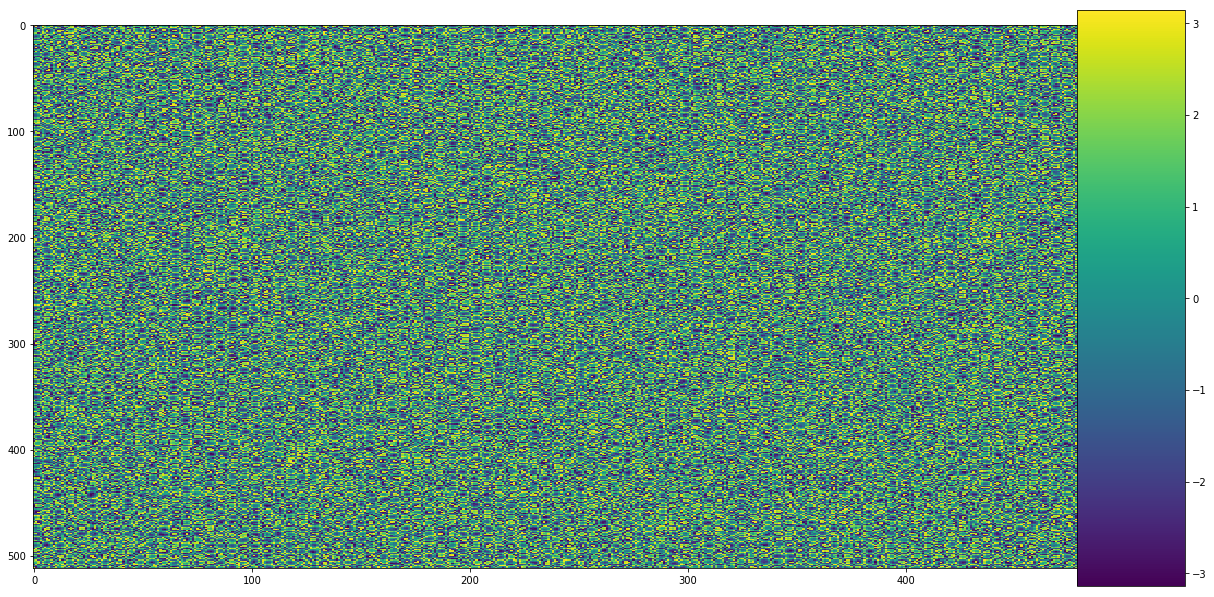

In [62]:
plt.rc('figure', figsize=[20,10])
plt.imshow(angs, aspect='auto')#.set_clim(0.0, 2)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [63]:
intensity.min()

0.0011420578564619245

In [64]:
intensity.max()

4.054761025643901

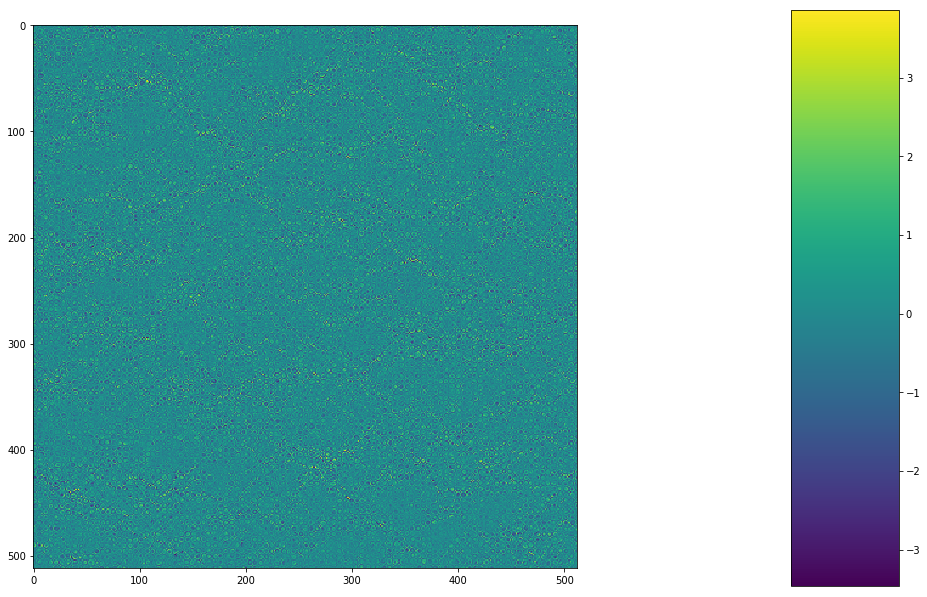

In [65]:
plt.imshow(sim.real)#.set_clim(0.0, 2)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

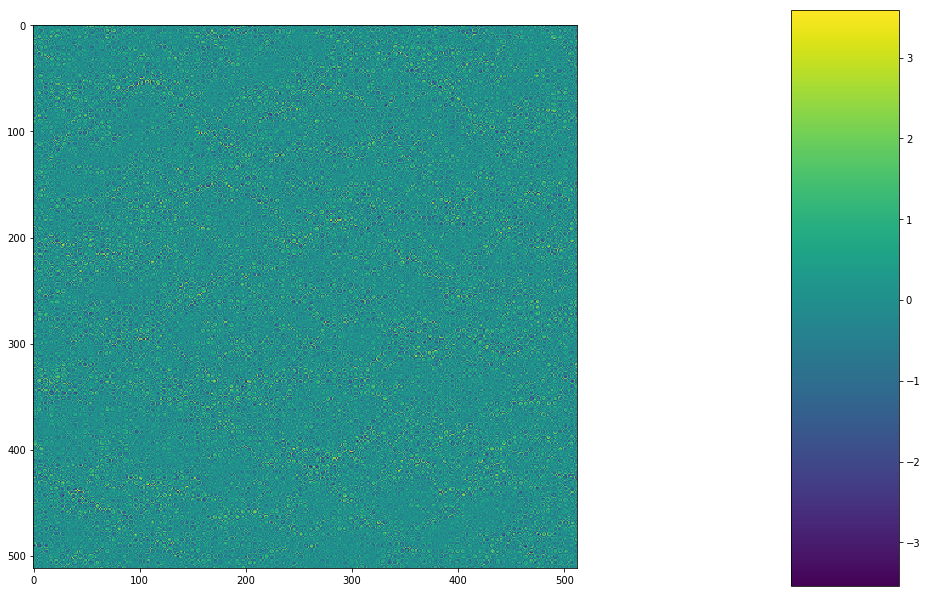

In [66]:
plt.imshow(sim.imag)#.set_clim(0.0, 2)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

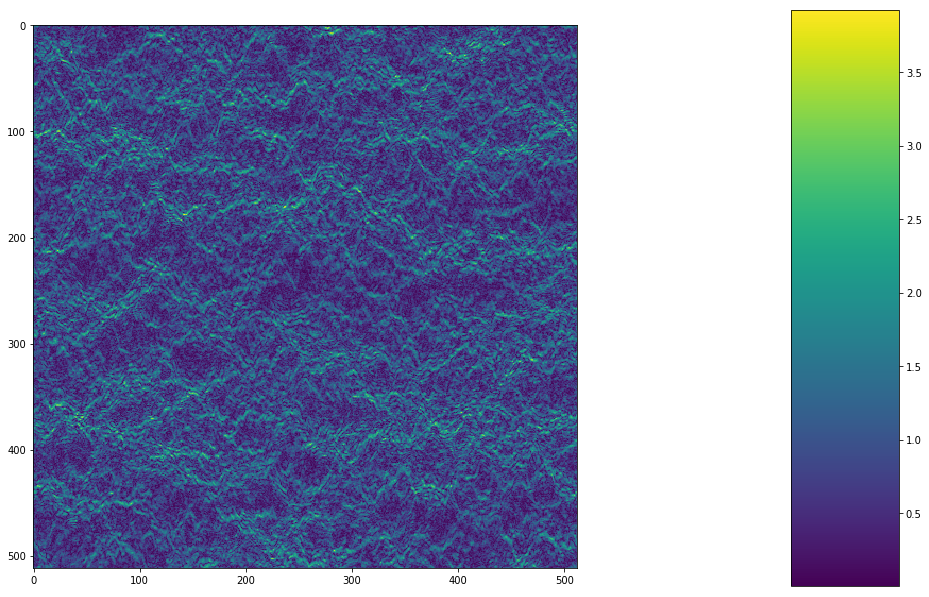

In [53]:
plt.imshow(intensity)#.set_clim(0.0, 4)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [68]:
varI=np.var(intensity**2)
meanI=np.mean(intensity**2)

In [69]:
print(varI, meanI)

1.1610868076098975 0.9999999999999827


In [22]:
varIntens = []
for i in range(50):
    sim = turbo_sim(10)
    intensity = np.sqrt(np.conjugate(sim) * sim).real
    varIntens.append(get_var(intensity))

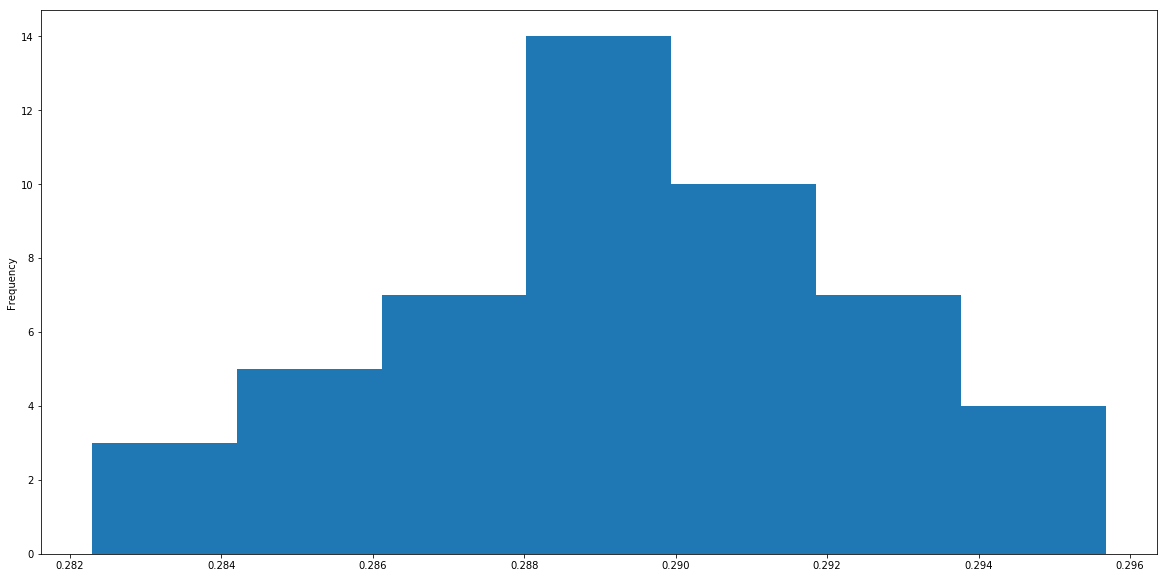

In [23]:
pd.Series(varIntens).plot(kind='hist', bins=7)

In [24]:
import numpy as np

In [25]:
((50e3/20)*0.423*(2*np.pi/1e-6)**2)**(-3/5)

1.0656532955434324e-10

In [26]:
(2*np.pi/1e-6)**2

39478417604357.44

In [27]:
(50e3)/20

2500.0

In [28]:
(((0.1)**(5/3))*0.423)*((np.pi/1e-6)**2)*((50e3)/20)

224860646392676.7

In [29]:
Cn2 = 1/((((0.1)**(5/3))*0.423)*((2*np.pi/1e-6)**2)*((50e3)/20))

In [30]:
Cn2

1.1117997035524934e-15

In [31]:
((2*np.pi/1e-6)**(7/6))*Cn2*0.312*((50e3)**(11/6))

12.194649874421183

In [32]:
((50e3)**(11/6))

411887243.1105161

In [33]:
4*Cn2

4.4471988142099735e-15

In [34]:
Cn2 = 1/((((0.1)**(5/3))*0.423)*((2*np.pi/1e-6)**2)*((10e3)/10))

In [35]:
Cn2

2.779499258881234e-15

In [36]:
((2*np.pi/1e-6)**(7/6))*Cn2*0.312*((10e3)**(11/6))

1.594646178152972